# ATP Tennis Data - Raw Player Stats + One Hot Encoding + Player History


In our previous [notebook](https://github.com/sv650s/sb-capstone2/blob/master/notebooks/5.0.2-atp_ohe.ipynb), we got the best performance when we used raw player stats and one hot encoded our categorical data

In this notebook, we will run the same algorithms but we will add historical data from player 1 and 2. Historical data was created in this [notebook](https://github.com/sv650s/sb-capstone2/blob/master/notebooks/3.1.0-apt_feature_engineering-history.ipynb) where we aggregated match data for each player for the most recent 5 matches leading up to sample in our data

History data that we obtained for both players:

* wins - matches won
* losses - matches lost
* games won
* sets won
* games lost
* sets lost

Percentage Data:
* winning percentage = wins / (wins + losses)
* games won percetnage = games won / (games won + games lost)
* sets won percentage = sets won / (sets won + sets lost)

Diff data:
* p1_history_win_percentage_diff - player 1 win percentage history - player 2 win percentage history
* p1_history_games_won_percentage_diff = player 1 games won percentage - player 2 games won percentage
* p1_history_sets_won_percentage_diff = player 1 sets won percetntage - player 2 sets won percentage
* p1_history_wins_diff = player 1 wins - player 2 wins
* p1_history_losses_diff = player 1 losses - player 2 losses


We will put all of these columns in our dataset and run it through our models to see if there are improvements

### Results from previous best model

```
Model Score: 0.6833220796758946

ROC/AUC Score: 0.6833051847604916
              precision    recall  f1-score   support

        Loss       0.68      0.68      0.68      7381
         Win       0.68      0.69      0.69      7429

    accuracy                           0.68     14810
   macro avg       0.68      0.68      0.68     14810
weighted avg       0.68      0.68      0.68     14810
```

# Summary of Results

* Grandient Boosting is still our best model
* Adding history data for both players increased accuracy slightly for all models except for Decision Tree and KNN

```
Model Score: 0.6906819716407833

ROC/AUC Score: 0.6906426130517523
              precision    recall  f1-score   support

        Loss       0.69      0.68      0.69      7381
         Win       0.69      0.70      0.70      7429

    accuracy                           0.69     14810
   macro avg       0.69      0.69      0.69     14810
weighted avg       0.69      0.69      0.69     14810
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from datetime import datetime
import pickle
import json
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util import jupyter_util as ju
from util.model_util import ModelWrapper, RSTATE, N_JOBS, MAX_ITER, LABEL_COL

%matplotlib inline
sns.set()


# date
DATE_FORMAT = '%Y-%m-%d'
DATE = datetime.now().strftime(DATE_FORMAT)

DESCRIPTION = "ohe-history_all"


# sometimes I run these notebooks via command line. Environment variable is set so we know whether we are in DEBUG mode or not
# if you want to manually run this in DEBUG mode, change default value to True
DEBUG = bool(os.environ.get("IPYNB_DEBUG", False))

if DEBUG:
    ModelWrapper.REPORT_FILE = '../reports/summary-test.csv'
    FEATURE_FILE = f'../datasets/atp_matches_1985-2019_features_test-ohe-history5-matchup5-stats5.csv'
    DESCRIPTION = f"{DESCRIPTION}-test"
else:
    # update this
    FEATURE_FILE = f'../datasets/atp_matches_1985-2019_features-ohe-history5-matchup5-stats5.csv'


START_YEAR = 1998
END_YEAR = 2018




In [2]:
import re

def filter_features(data: pd.DataFrame):
    print(f'Before: data.shape {data.shape} data.shape {data.shape}')
    
    matchup_columns = [col for col in data.columns if re.search("matchup", col)]
    data = data.drop(matchup_columns, axis=1)
    
    stats_columns = [col for col in data.columns if re.search("stats", col)]
    data = data.drop(stats_columns, axis=1)
    
    print(f'After: data.shape {data.shape} data.shape {data.shape}')
    
    return data
    

In [3]:
X_train, X_test, y_train, y_test = ju.get_data(FEATURE_FILE, LABEL_COL, START_YEAR, END_YEAR, data_filter = filter_features)

Before: data.shape (59239, 5371) data.shape (59239, 5371)
After: data.shape (59239, 5282) data.shape (59239, 5282)


In [4]:
[col for col in X_train.columns if re.search("history", col)]

['p1_history_games_lost',
 'p1_history_games_won',
 'p1_history_games_won_percentage',
 'p1_history_losses',
 'p1_history_sets_lost',
 'p1_history_sets_won',
 'p1_history_sets_won_percentage',
 'p1_history_win_percentage',
 'p1_history_wins',
 'p2_history_games_lost',
 'p2_history_games_won',
 'p2_history_games_won_percentage',
 'p2_history_losses',
 'p2_history_sets_lost',
 'p2_history_sets_won',
 'p2_history_sets_won_percentage',
 'p2_history_win_percentage',
 'p2_history_wins',
 'p1_history_win_percentage_diff',
 'p1_history_games_won_percentage_diff',
 'p1_history_sets_won_percentage_diff',
 'p1_history_wins_diff',
 'p1_history_losses_diff',
 'p1_history_matches',
 'p2_history_matches']

Our dataset actually has both historical data as well as matchup data. We will remove the matchup columns from the dataset

# Logistic Regression

In [5]:

# train our model

lr = ModelWrapper(LogisticRegression(n_jobs = N_JOBS, verbose = 1, random_state = RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = filter_features).fit()
y_predict_lr = lr.predict()

/Users/vinceluk/anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/vinceluk/anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]

Model Score: 0.6634031060094531

ROC/AUC Score: 0.6634006644375041
              precision    recall  f1-score   support

        Loss       0.66      0.66      0.66      7381
         Win       0.66      0.66      0.66      7429

    accuracy                           0.66     14810
   macro avg       0.66      0.66      0.66     14810
weighted avg       0.66      0.66      0.66     14810

      Loss   Win
Loss  4891  2490
Win   2495  4934


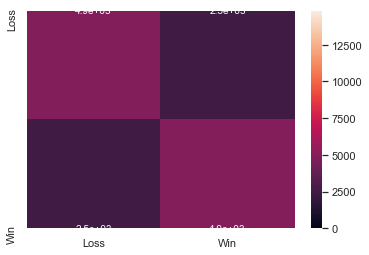

In [6]:
lr.analyze()

In [7]:
# ju.plot_2d(X_test, y_predict_lr)

In [8]:
lr.save()

Saving report: ../reports/summary.csv


# KNN

In [9]:

# train our model

knn = ModelWrapper(KNeighborsClassifier(n_jobs = N_JOBS),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = filter_features).fit()
y_predict_knn = knn.predict()

TypeError: fit() takes 3 positional arguments but 4 were given

In [10]:
knn.analyze()

NameError: name 'knn' is not defined

In [11]:
# ju.plot_2d(X_test, y_predict_knn)

In [12]:
knn.save()

NameError: name 'knn' is not defined

# Decision Tree

In [13]:

# train our model

dt = ModelWrapper(DecisionTreeClassifier(random_state = RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = filter_features).fit()
y_predict_dt = dt.predict()

Model Score: 0.6019581363943282

ROC/AUC Score: 0.6019834991594273
              precision    recall  f1-score   support

        Loss       0.60      0.61      0.60      7381
         Win       0.61      0.59      0.60      7429

    accuracy                           0.60     14810
   macro avg       0.60      0.60      0.60     14810
weighted avg       0.60      0.60      0.60     14810

      Loss   Win
Loss  4501  2880
Win   3015  4414


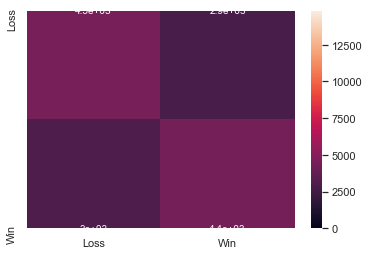

In [14]:
dt.analyze()

In [15]:
# ju.plot_2d(X_test, y_predict_dt)

In [16]:
dt.save()

Saving report: ../reports/summary.csv


# Random Forest Classifier

In [17]:

# train our model

rf = ModelWrapper(RandomForestClassifier(random_state=RSTATE, verbose=1),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = filter_features).fit()
y_predict_rf = rf.predict()

/Users/vinceluk/anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


Model Score: 0.6163403106009453

ROC/AUC Score: 0.6165853255008636
              precision    recall  f1-score   support

        Loss       0.60      0.69      0.64      7381
         Win       0.64      0.54      0.59      7429

    accuracy                           0.62     14810
   macro avg       0.62      0.62      0.61     14810
weighted avg       0.62      0.62      0.61     14810

      Loss   Win
Loss  5109  2272
Win   3410  4019


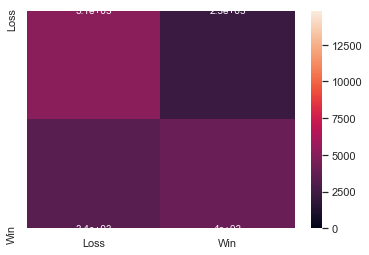

In [18]:
rf.analyze()

In [19]:
# ju.plot_2d(X_test, y_predict_rf)

In [20]:
rf.save()

Saving report: ../reports/summary.csv


# Gradient Boosting

In [21]:

# train our model

gb = ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = filter_features).fit()
y_predict_gb = gb.predict()

      Iter       Train Loss   Remaining Time 
         1           1.3661           11.57m
         2           1.3496           11.19m
         3           1.3353           11.00m
         4           1.3232           10.82m
         5           1.3127           10.63m
         6           1.3036           10.48m
         7           1.2961           10.31m
         8           1.2883           10.17m
         9           1.2819           10.04m
        10           1.2764            9.92m
        20           1.2332            8.73m
        30           1.2056            7.58m
        40           1.1924            6.47m
        50           1.1840            5.37m
        60           1.1744            4.42m
        70           1.1618            3.30m
        80           1.1576            2.25m
        90           1.1504            1.14m
       100           1.1481            0.00s


Model Score: 0.6906819716407833

ROC/AUC Score: 0.6906426130517523
              precision    recall  f1-score   support

        Loss       0.69      0.68      0.69      7381
         Win       0.69      0.70      0.70      7429

    accuracy                           0.69     14810
   macro avg       0.69      0.69      0.69     14810
weighted avg       0.69      0.69      0.69     14810

      Loss   Win
Loss  5008  2373
Win   2208  5221


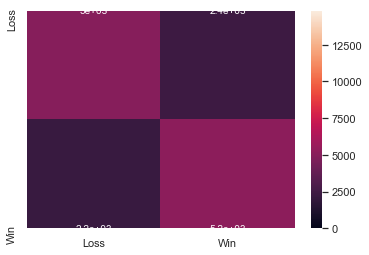

In [22]:
gb.analyze()

In [23]:
# ju.plot_2d(X_test, y_predict_gb)

In [24]:
gb.save()

Saving report: ../reports/summary.csv


# AdaBoost

In [25]:
ab = ModelWrapper(AdaBoostClassifier(random_state=RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test, data_filter = filter_features).fit()
y_predict_ab = ab.predict()

Model Score: 0.6723835246455098

ROC/AUC Score: 0.6723455057514256
              precision    recall  f1-score   support

        Loss       0.68      0.66      0.67      7381
         Win       0.67      0.68      0.68      7429

    accuracy                           0.67     14810
   macro avg       0.67      0.67      0.67     14810
weighted avg       0.67      0.67      0.67     14810

      Loss   Win
Loss  4876  2505
Win   2347  5082


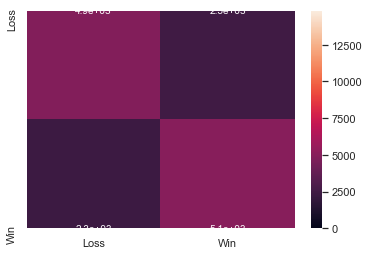

In [26]:
ab.analyze()

In [27]:
# ju.plot_2d(X_test, y_predict_ab)

In [28]:
ab.save()

Saving report: ../reports/summary.csv


# Results


In [29]:
report = pd.read_csv(ModelWrapper.REPORT_FILE)
report.tail(6)

,accuracy,classification_report,confusion_matrix,data_file,data_filter_file,description,end_year,fit_time_min,model_file,model_name,predict_time_min,roc_auc_score,start_year,total_time_min
179,0.663403,"{""Loss"": {""precision"": 0.6621987544002166, ""re...","{""0"": {""0"": 4891, ""1"": 2495}, ""1"": {""0"": 2490,...",../datasets/atp_matches_1985-2019_features-ohe...,../models/logisticregression-1998-2018-ohe-his...,ohe-history_all,2018,0.0,../models/logisticregression-1998-2018-ohe-his...,LogisticRegression,0.0,0.663401,1998,0.0
180,0.601958,"{""Loss"": {""precision"": 0.5988557743480575, ""re...","{""0"": {""0"": 4501, ""1"": 3015}, ""1"": {""0"": 2880,...",../datasets/atp_matches_1985-2019_features-ohe...,../models/decisiontreeclassifier-1998-2018-ohe...,ohe-history_all,2018,0.0,../models/decisiontreeclassifier-1998-2018-ohe...,DecisionTreeClassifier,0.0,0.601983,1998,0.0
181,0.616340,"{""Loss"": {""precision"": 0.5997182767930508, ""re...","{""0"": {""0"": 5109, ""1"": 3410}, ""1"": {""0"": 2272,...",../datasets/atp_matches_1985-2019_features-ohe...,../models/randomforestclassifier-1998-2018-ohe...,ohe-history_all,2018,0.0,../models/randomforestclassifier-1998-2018-ohe...,RandomForestClassifier,0.0,0.616585,1998,0.0
182,0.690682,"{""Loss"": {""precision"": 0.6940133037694013, ""re...","{""0"": {""0"": 5008, ""1"": 2208}, ""1"": {""0"": 2373,...",../datasets/atp_matches_1985-2019_features-ohe...,../models/gradientboostingclassifier-1998-2018...,ohe-history_all,2018,11.0,../models/gradientboostingclassifier-1998-2018...,GradientBoostingClassifier,0.0,0.690643,1998,11.0
183,0.659673,"{""Loss"": {""precision"": 0.6636023429873088, ""re...","{""0"": {""0"": 8157, ""1"": 4135}, ""1"": {""0"": 4365,...",../datasets/atp_matches_1985-2019_features-raw...,../models/gradientboostingclassifier-1985-2018...,ohe-stats-stats_diff-weights_bin1,2018,23.0,../models/gradientboostingclassifier-1985-2018...,GradientBoostingClassifier,0.0,0.659696,1985,23.0
184,0.672384,"{""Loss"": {""precision"": 0.6750657621486916, ""re...","{""0"": {""0"": 4876, ""1"": 2347}, ""1"": {""0"": 2505,...",../datasets/atp_matches_1985-2019_features-ohe...,../models/adaboostclassifier-1998-2018-ohe-his...,ohe-history_all,2018,1.0,../models/adaboostclassifier-1998-2018-ohe-his...,AdaBoostClassifier,0.0,0.672346,1998,1.0


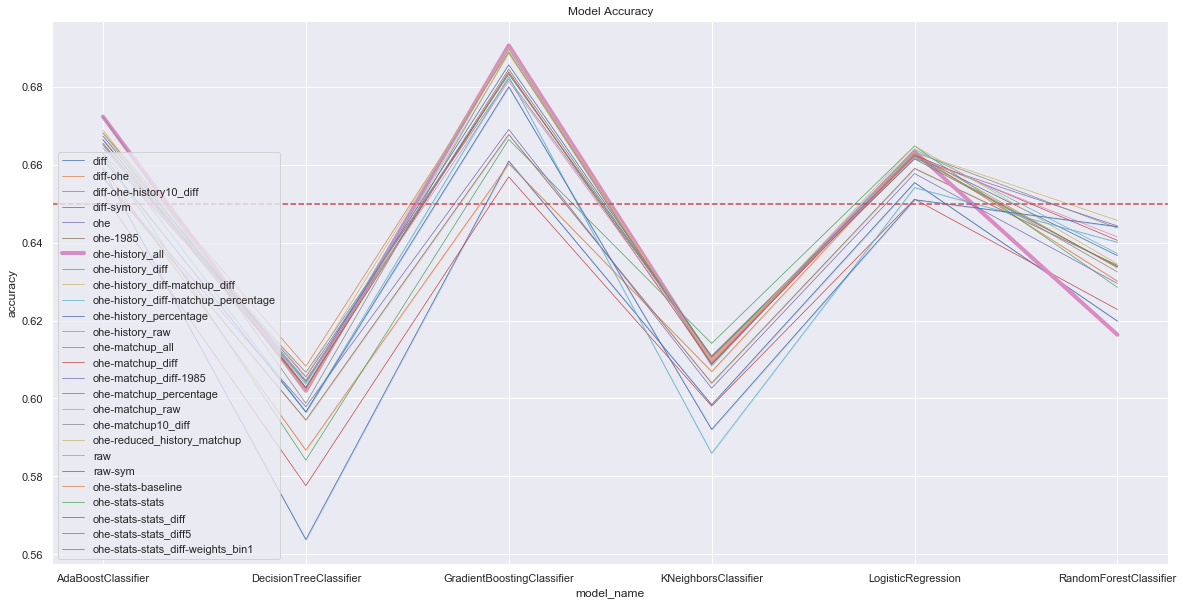

In [30]:
f, a = plt.subplots(1, 1, figsize=(20, 10))

descs = report.description.unique()

for desc in descs:
    report_desc = report[report.description == desc]
    if desc == DESCRIPTION:
        sns.lineplot(x="model_name", y="accuracy", data=report_desc, label=desc, linewidth=4)
    else:
        sns.lineplot(x="model_name", y="accuracy", data=report_desc, label=desc, linewidth=0.75)

a.axhline(0.65, ls='--', color='r')
a.set_title(f"Model Accuracy")
_ = a.legend(loc="lower left")

Best Model: GradientBoostingClassifier


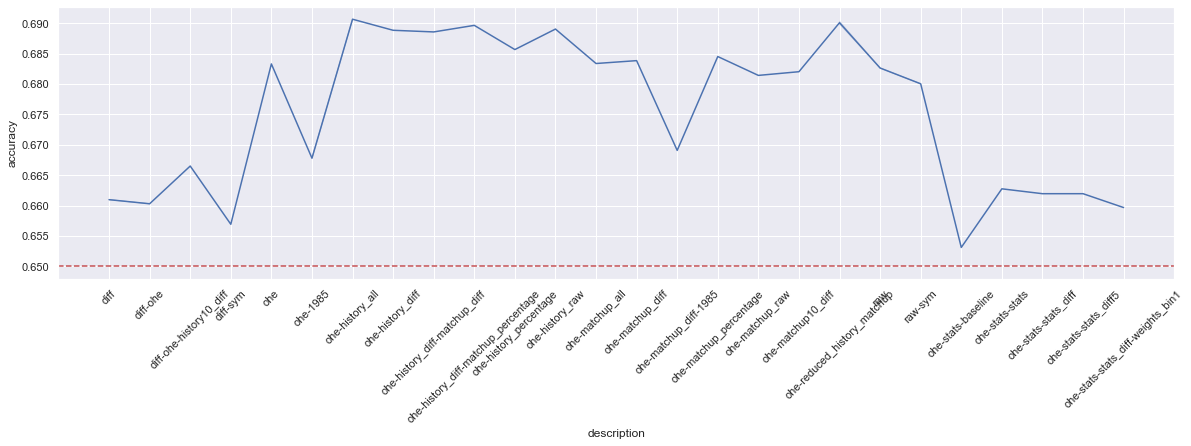

In [31]:
best_model = report.loc[report[report.description == DESCRIPTION].accuracy.idxmax()].model_name
print(f'Best Model: {best_model}')

dt_report = report[(report.model_name == best_model)]

f, a = plt.subplots(1, 1, figsize=(20, 5))
_ = sns.lineplot(x="description", y="accuracy", data=dt_report, ax=a, sort=False)
_ = a.axhline(0.65, ls='--', color='r')
_ = a.set_label(f"{best_model} Accuracy")
_ = plt.xticks(rotation=45)


In [32]:
current_report = report[(report.model_name == 'GradientBoostingClassifier') &
                                  (report.description == DESCRIPTION)]
mw = ModelWrapper.get_model_wrapper_from_report(current_report)


AssertionError: data must of length 1 - got 2

In [33]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(mw.model, data=X_train.values)
shap_values = explainer.shap_values(X_test.values)

NameError: name 'mw' is not defined

In [34]:
shap.summary_plot(shap_values, X_test, max_display=30)

NameError: name 'shap_values' is not defined

In [35]:
shap.summary_plot(shap_values, feature_names=X_test.columns, title="Feature Importance")

NameError: name 'shap_values' is not defined

In [36]:
print(f'Last Finished: {datetime.now().strftime("%Y-%m-%d %H:%M")}')

Last Finished: 2019-10-26 11:48
